In [71]:
import numpy as np
import os
import time
from IPython import display
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50V2


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
# We will use all images. You can use only the training set if you want
all_images = np.concatenate([x_train, x_test])
all_labels = np.concatenate([y_train, y_test])

In [5]:
# Scale the pixel values to [0, 1] range
all_images = all_images.astype("float32") / 255.0

In [7]:
# Batch and shuffle the data
BUFFER_SIZE = 1024
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(all_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print(f"Shape of training images: {all_images.shape}")
print(f"Shape of training labels: {all_labels.shape}")

Shape of training images: (60000, 32, 32, 3)
Shape of training labels: (60000, 1)


# GAN without conditional property

In [44]:
# Generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Use sigmoid activation in final layer if your images are normalized between 0-1
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='sigmoid'))
    assert model.output_shape == (None, 32, 32, 3)

    return model

In [45]:
# Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [46]:
# Cross entropy loss from logits
# Since this is calculated from logits, note that we have linear activation in the last layer of the discriminator instead of sigmoid
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
# Loss function for the discriminator
# Note that real images are labeled 1 and fake images are labeled 0
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [48]:
# Loss function for the generator
# If the discriminator classifies fake images (class 0) as real (class 1), the loss is lowest
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [49]:
# Generator and discriminator optimizers
# Note that they can be different if needed
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [50]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [51]:
# We will save checkpoints of the model
# This is helpful to restart training if it is interrupted, e.g., if colab times you out
# Ideally the folder location should be in your Google drive if you are running on colab
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [52]:
# Training hyerparameters
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [53]:
# The train_step function
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [63]:
# Function to generate images using the generator and save them
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow((np.asarray(predictions[i, :, :, :]) * 255).astype('int'))
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [64]:
# Train function
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


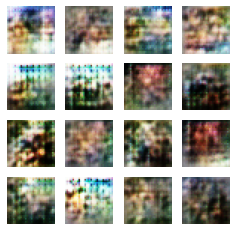

In [65]:
# start training
train(train_dataset, EPOCHS)


# Frechet Inception Distance

In [77]:
# Frechet Inception Distance
def Frechet_inception_distance(model, real_images, fake_images):
  # We should typically use InceptionV3 without the top layer as the model 

  # Get image features
  feat_real = model.predict(real_images)
  feat_fake = model.predict(fake_images)

  # calculate mean and covariance
  mu_real, sigma_real = feat_real.mean(axis=0), np.cov(feat_real, rowvar=False)
  mu_fake, sigma_fake = feat_fake.mean(axis=0), np.cov(feat_fake, rowvar=False)

  # calculate sum squared difference between means
  ssdiff = np.sum((mu_real - mu_fake)**2.0)

  # calculate sqrt of product between cov
  covmean = sqrtm(sigma_real.dot(sigma_fake))


  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real

  # calculate score
  fid = ssdiff + np.trace(sigma_real + sigma_fake - 2.0 * covmean)

  return fid

In [78]:
# prepare the inception v3 model
inception_model = ResNet50V2(include_top=False, pooling='avg', input_shape=(32,32,3))

In [79]:
fake_images = generator(seed, training=False)
fid = Frechet_inception_distance(inception_model, all_images, fake_images)
print('Frechet Inception Distance =', fid)

1/1 [==============================] - 1s 728ms/step
Frechet Inception Distance = 128.4203839818761


In [80]:
# What would be the Frechet Inception Distance if the images were of excellent quality?
# Let us find the Frechet distance between the train and test images in the dataset
# It would ideally be very low.

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
fid = Frechet_inception_distance(inception_model, x_train, x_test)
print('Frechet Inception Distance =', fid)


313/313 [==============================] - 3s 11ms/step
Frechet Inception Distance = 3.082247320330719


# Conditional GAN

In [94]:
# This solution uses the embedding idea
# You can use any other idea for cGAN

def define_discriminator(in_shape=(32,32,3), n_classes=10):
	# label input
	in_label = layers.Input(shape=(1,))
	# embedding for categorical input
	li = layers.Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = layers.Dense(n_nodes)(li)
	# reshape to additional channel
	li = layers.Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = layers.Input(shape=in_shape)
	# concat label as a channel
	merge = layers.Concatenate()([in_image, li])
	# downsample
	fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = layers.LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = layers.Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = layers.LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = layers.Flatten()(fe)
	# dropout
	fe = layers.Dropout(0.4)(fe)
	# output
	out_layer = layers.Dense(1, activation='sigmoid')(fe)
	# define model
	model = tf.keras.models.Model([in_image, in_label], out_layer)
	# compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [95]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = layers.Input(shape=(1,))
	# embedding for categorical input
	li = layers.Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 8 * 8
	li = layers.Dense(n_nodes)(li)
	# reshape to additional channel
	li = layers.Reshape((8, 8, 1))(li)
	# image generator input
	in_lat = layers.Input(shape=(latent_dim,))
	# foundation for 8x8 image
	n_nodes = 128 * 8 * 8
	gen = layers.Dense(n_nodes)(in_lat)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	gen = layers.Reshape((8, 8, 128))(gen)
	# merge image gen and label input
	merge = layers.Concatenate()([gen, li])
	# upsample to 16x16
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = layers.LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = layers.Conv2D(3, (7,7), activation='sigmoid', padding='same')(gen)
	# define model
	model = tf.keras.models.Model([in_lat, in_label], out_layer)
	return model

In [96]:
# Define the GAN model
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = tf.keras.models.Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

In [97]:
# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = np.random.randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [98]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=30, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = np.ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

In [99]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = [all_images, all_labels]
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 12ms/step
>25, 309/468, d1=0.693, d2=0.695 g=0.708
2/2 [==============================] - 0s 6ms/step
>25, 310/468, d1=0.690, d2=0.684 g=0.711
2/2 [==============================] - 0s 15ms/step
>25, 311/468, d1=0.695, d2=0.693 g=0.704
2/2 [==============================] - 0s 15ms/step
>25, 312/468, d1=0.687, d2=0.694 g=0.705
2/2 [==============================] - 0s 13ms/step
>25, 313/468, d1=0.690, d2=0.696 g=0.708
2/2 [==============================] - 0s 10ms/step
>25, 314/468, d1=0.693, d2=0.692 g=0.700
2/2 [==============================] - 0s 5ms/step
>25, 315/468, d1=0.704, d2=0.695 g=0.693
2/2 [==============================] - 0s 11ms/step
>25, 316/468, d1=0.691, d2=0.698 g=0.697
2/2 [==============================] - 0s 12ms/step
>25, 317/468, d1=0.690, d2=0.708 g=0.705
2/2 [==============================] - 0s 11ms/step
>25, 318/468, d1=0.688, d2=0.697 g=0.703
2/2 [================

>30, 468/468, d1=0.690, d2=0.696 g=0.699


4/4 [==============================] - 0s 8ms/step


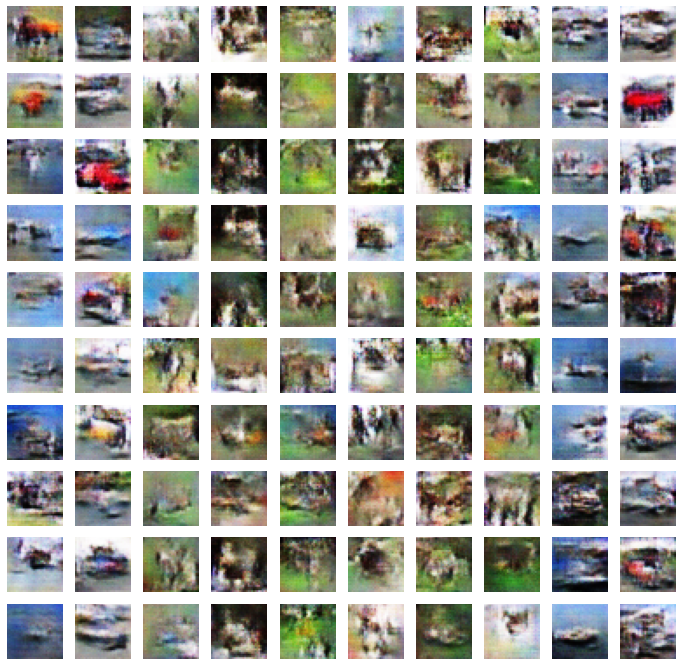

In [103]:
# plot generator outputs
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]
 
# create and save a plot of generated images
def plot_generated(examples, n):
  # plot images
  fig = plt.figure(figsize=(12, 12))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, :])
 
# load model
model = tf.keras.models.load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = np.asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# plot the result
plot_generated(X, 10)

In [104]:
# Compute Frechet Inception distance
fid = Frechet_inception_distance(inception_model, all_images, X)
print('Frechet Inception Distance =', fid)

4/4 [==============================] - 0s 8ms/step
Frechet Inception Distance = 52.297408861967085
